# Least Squares Assignment
---

The goal of this assignment is to achieve uniform lighting in a room by utilizing 10 lamps with varying power.

In [1]:
import math
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Data Preprocessing
---

As a first step, we will initialize the lamp coordinates, as well as the illumination and power lists. List `p` contains the power of the lamps and has a shape of `10x1`. List `l` contains the illumination pattern and has a shape of `625x1` for a given room of `25x25` pixels:

In [2]:
# initialization of power of ones (10 x 1)
p_ones = np.array([1 for i in range (10)]).T
l_ones = np.array([1 for i in range (625)]).T

# initialization of lamps
lamps = [
    [4.10, 20.4, 4.0], [14.1, 21.3, 3.5], 
    [22.6, 17.1, 6.0], [5.50, 12.3, 4.0], 
    [12.2, 9.70, 4.0], [15.3, 13.8, 6.0], 
    [21.3, 10.5, 5.5], [3.90, 3.30, 5.0],
    [13.1, 4.30, 5.0], [20.3, 4.20, 4.5]
]
lamps = np.array(lamps)

Matrix `A` contains information on illumination patters. The j-th column of `A` gives the illumination pattern for lamp j, if no other lamp is active in the room. The i-th row of `A` gives the sensitivity of pixel i to the n lamp powers. Matrix `A` has, consequently, a shape of `625x10`:

In [3]:
# initialization of A matrix (10 x 625)
acc = []
for l in lamps:
    curr_row = []
    x, y, z = l[0], l[1], l[2]
    for i in range(1, 26):
        curr_col = []
        for j in range(1, 26):
            dist = math.sqrt(
                (x-i) ** 2 + (y-j) ** 2 + l[2] ** 2
            ) ** (-2)
            curr_col.append(dist)
        curr_row.append(curr_col)
    acc.append(curr_row)

fin = []
for i in range(10):
    curr = [item for sublist in acc[i] for item in sublist]
    fin.append(curr)
    
A = np.array(fin).T

## All lamp powers set to 1
---

The equation that describes our problem is:

$$
    Ap = l
$$

where we set the vector `p` equal to ones:

In [4]:
# calculation of l for p_ones (625 x 1)
l_unsol = A @ p_ones

# calculate rms
rmse = mean_squared_error(l_ones, l_unsol)
print('RMSE: {:.2f}'.format(rmse))

RMSE: 0.82


The illumination of the room and the corresponding illumination histogram are:

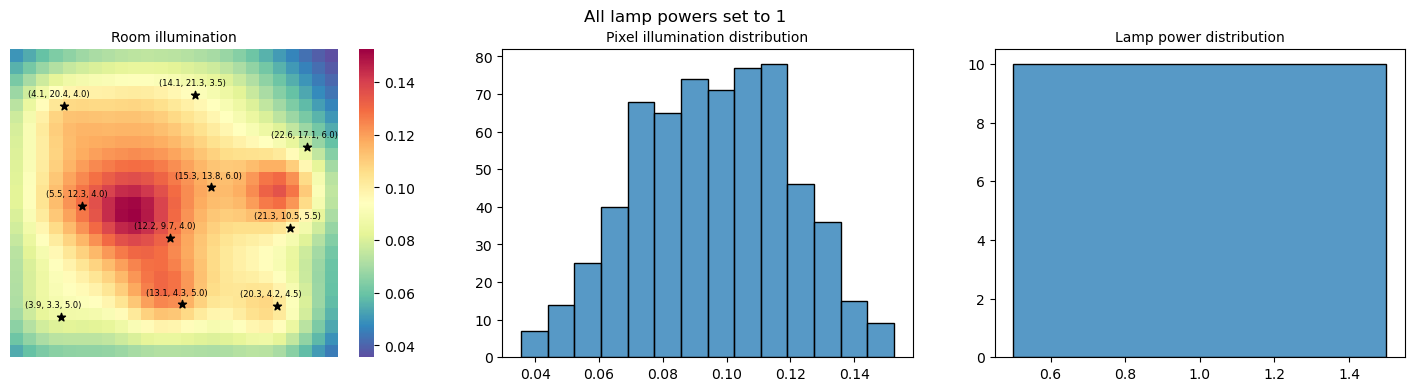

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('All lamp powers set to 1')

# heatmap
sns.heatmap(
    l_unsol.reshape(25, 25), 
    ax=axes[0],
    linewidth=0,
    xticklabels=[], 
    yticklabels=[],
    cmap=sns.color_palette("Spectral_r", as_cmap=True)
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], 
    lamps[:, 1],
    marker='*', 
    color='black'
)
axes[0].set_title('Room illumination', fontsize=10)
axes[0].invert_yaxis()

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-2.75, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# pixel histogram
sns.histplot(ax=axes[1], x=l_unsol)
axes[1].set_title('Pixel illumination distribution', fontsize=10)
axes[1].set(ylabel='')

# lamp histogram
sns.histplot(ax=axes[2], x=p_ones)
axes[2].set_title('Lamp power distribution', fontsize=10)
axes[2].set(ylabel='')

plt.show()

Taking a closer look to the produced histogram we can notice how the state of illumination is far from ideal, since no pixel has an illumination of 1.

## Solving the least squares problem
---

The closed form of the solution for the LS problem is:

$$
    p = (A^TA)^{-1}A^Tl
$$

where the vector `l` is set to ones:

In [6]:
# calculating power for unfirom lighting
p_sol = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), l_ones)

# calculation of l for p_ones (625 x 1)
l_sol = A @ p_sol

# calculate rms
rmse = mean_squared_error(l_ones, l_sol)
print('RMSE: {:.2f}'.format(rmse))

RMSE: 0.02


In [7]:
print('Lamp powers:')
for p in p_sol:
    print('{:.2f}'.format(p), end=" ")

Lamp powers:
15.25 8.67 32.12 7.65 1.67 0.39 2.83 20.60 8.95 15.22 

We notice how the RMSE is significantly smaller than the one of the previous section. The illumination of the room and the corresponding illumination histogram are:

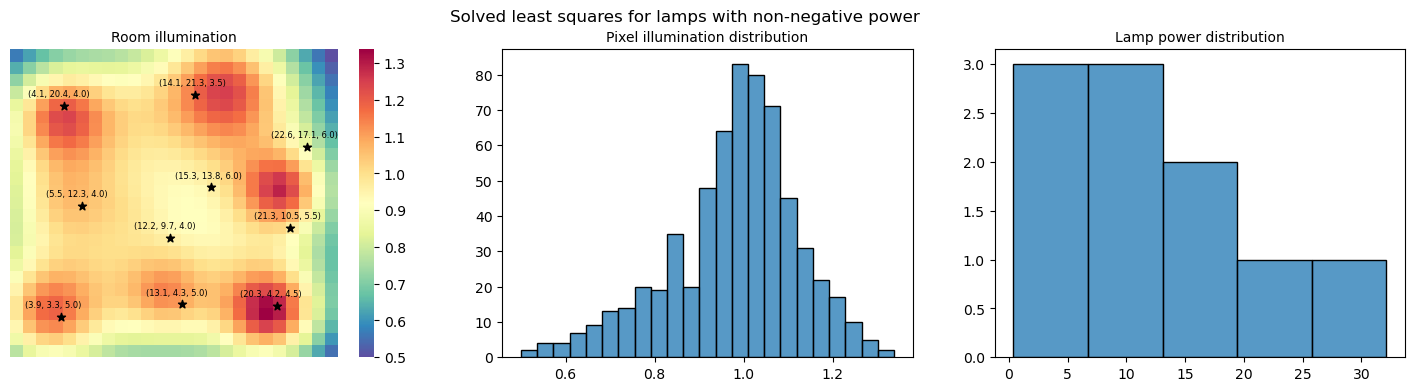

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('Solved least squares for lamps with non-negative power')

# heatmap
sns.heatmap(
    l_sol.reshape(25, 25), 
    ax=axes[0],
    linewidth=0,
    xticklabels=[], 
    yticklabels=[],
    cmap=sns.color_palette("Spectral_r", as_cmap=True)
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], 
    lamps[:, 1],
    marker='*', 
    color='black'
)
axes[0].set_title('Room illumination', fontsize=10)
axes[0].invert_yaxis()

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-2.75, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# pixel histogram
sns.histplot(ax=axes[1], x=l_sol)
axes[1].set_title('Pixel illumination distribution', fontsize=10)
axes[1].set(ylabel='')

# lamp histogram
sns.histplot(ax=axes[2], x=p_sol)
axes[2].set_title('Lamp power distribution', fontsize=10)
axes[2].set(ylabel='')

plt.show()

The histogram produces an image closer to uniformity, than in the case when all lamps were set to power of 1. Comparing the histograms of the two cases, it becomes also apparent that the solution of the LS problem is closer to the ideal state of illumnination with more pixels fluctuating around 1.

## Solving the constrained least squares problem
---

The problem statement for the problem now becomes:

$$
    argmin ||Ap - l||_2 ^2
$$

under the constraint:

$$
    \sum \limits _{i=1} ^{10} p_i=10, p_i \ge 0
$$

In [10]:
def minimization_function(p):
    """
    L2 norm minimization function
    """
    
    return np.linalg.norm(
        np.dot(A, p) - l_ones, ord=2
    ) ** 2

cons = [{
    'type': 'eq',
    # sum of powers equal to 10 constraint
    'fun': lambda p: np.sum(p) - 10 
}]

res = scipy.optimize.minimize(
    fun=minimization_function,
    x0=p_sol, 
    method='SLSQP',
    bounds = [(0, 10) for p in range(10)],
    constraints=cons
)

p_solc = res.x
print('Lamp powers:')
for p in p_solc:
    print('{:.2f}'.format(p), end=" ")

Lamp powers:
0.00 2.86 0.00 0.00 7.14 0.00 0.00 0.00 0.00 0.00 

In [11]:
# calculation of l for p_ones (625 x 1)
l_solc = A @ p_solc

# calculate rms
rmse = mean_squared_error(l_ones, l_solc)
print('RMSE: {:.2f}'.format(rmse))

RMSE: 0.77


We can see that the minimization function reached a local minimum where indeed the sum of powers is equal to one, but only 2 lamps are active. The RMSE is smaller to the initial state but far from better when compared to the solution of the unconstrained LS problem. This behaviour is expected since a solution for a constraint problem performs the same or worse than from the solution of the unconstrained one.

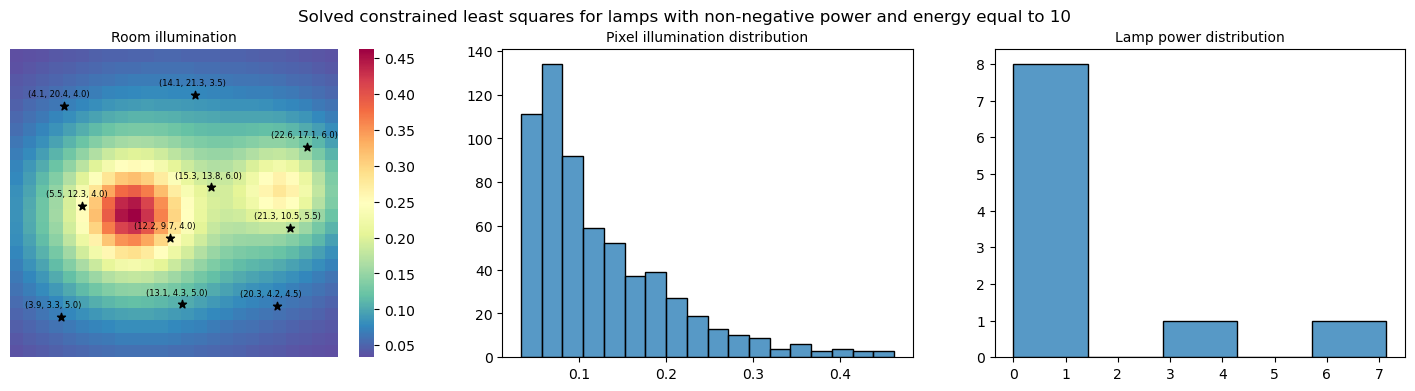

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle(
    'Solved constrained least squares for lamps with non-negative power and energy equal to 10'
)

# heatmap
sns.heatmap(
    l_solc.reshape(25, 25), 
    ax=axes[0],
    linewidth=0,
    xticklabels=[], 
    yticklabels=[],
    cmap=sns.color_palette("Spectral_r", as_cmap=True)
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], 
    lamps[:, 1],
    marker='*', color='black'
)
axes[0].set_title('Room illumination', fontsize=10)
axes[0].invert_yaxis()

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-2.75, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# pixel histogram
sns.histplot(ax=axes[1], x=l_solc)
axes[1].set_title('Pixel illumination distribution', fontsize=10)
axes[1].set(ylabel='')

# lamp histogram
sns.histplot(ax=axes[2], x=np.round(p_solc, 2))
axes[2].set_title('Lamp power distribution', fontsize=10)
axes[2].set(ylabel='')

plt.show()

## Challenge: Finding a better position for the lamps
---

A generation procedure was carried out in order to find lamp positions that would enable the optimal solution of the constraint least squares problem; a solution that would produce a RMSE lower than the one of the solution of the unconstraint problem. However, after numerous repetitions, no such solution was found. Further testing is necessary for disabling the solver to get caught up to local minimums.

For reference, we will use this part of the code to generate 3 lamp layouts with a better RMSE, keeping the constraint of positive powers, **but now discarding the constraint of energy adding up to 10**:

In [16]:
flag = 0
lamps_acc = []
rmse_acc, l_sol_acc, p_sol_acc = [], [], []

while flag < 3:
    
    # generating random coordinates and heights
    x = np.random.uniform(low=0.0, high=25.0, size=10)
    y = np.random.uniform(low=0.0, high=25.0, size=10)
    z = np.random.uniform(low=4.0, high=6.00, size=10)
    lamps = np.array([i for i in zip(x, y, z)])
    
    # calculating new A matrix
    acc = []
    for l in lamps:
        curr_row = []
        x, y, z = l[0], l[1], l[2]
        for i in range(1, 26):
            curr_col = []
            for j in range(1, 26):
                dist = math.sqrt(
                    (x-i) ** 2 + (y-j) ** 2 + l[2] ** 2
                ) ** (-2)
                curr_col.append(dist)
            curr_row.append(curr_col)
        acc.append(curr_row)
    fin = []
    for i in range(10):
        curr = [item for sublist in acc[i] for item in sublist]
        fin.append(curr)
    A = np.array(fin).T
    
    # solving constraint
    res = scipy.optimize.minimize(
        fun=minimization_function,
        x0=p_sol, 
        method='SLSQP',
        # bounds = [(0, 10) for p in range(10)],
        # constraints=cons
    )
    p_sol = res.x
    l_sol = A @ p_sol

    # calculating rms
    rmse = mean_squared_error(l_ones, l_sol)
    
    # check non-negativity
    if rmse < 0.015 and np.prod(p_sol > 0) == 1:
        flag += 1
        rmse_acc.append(rmse)
        lamps_acc.append(lamps)
        l_sol_acc.append(l_sol)
        p_sol_acc.append(p_sol)

print('Lamp powers:')
for p_list in p_sol_acc:
    for p in p_list:
        print('{:.2f}'.format(p), end=" ")
    print()

Lamp powers:
5.45 12.95 1.00 20.14 26.34 12.46 24.77 6.39 9.42 21.41 
10.65 0.79 12.97 20.20 30.78 19.20 11.93 8.07 14.59 1.48 
14.63 17.49 10.06 18.60 9.65 1.29 22.18 11.66 16.74 24.29 


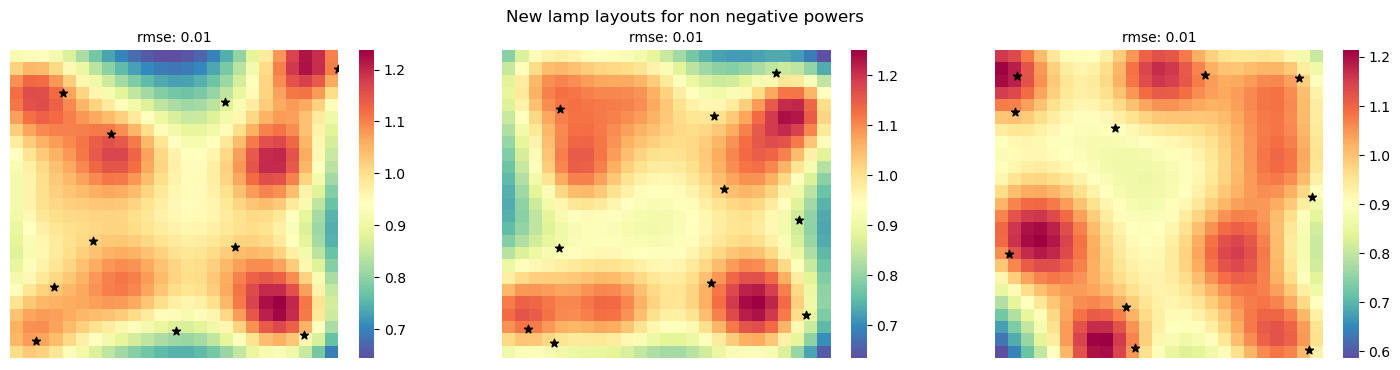

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('New lamp layouts for non negative powers')

for i in range(3):
    # heatmap
    sns.heatmap(
        l_sol_acc[i].reshape(25, 25), 
        ax=axes[i],
        linewidth=0,
        xticklabels=[], 
        yticklabels=[],
        cmap=sns.color_palette("Spectral_r", as_cmap=True)
    )

    # plotting lamps coordinates
    axes[i].scatter(
        lamps_acc[i][:, 0], 
        lamps_acc[i][:, 1],
        marker='*', 
        color='black'
    )
    axes[i].invert_yaxis()

    axes[i].set_title('rmse: {:.2f}'.format(rmse_acc[i]), fontsize=10)
    
plt.show()